### Visualizing the distribution of the observations

### Load the required libraries

In [22]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
##file_index for PID: A53201095
file_index='SBSSBSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12619
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    42|[40 4C 80 4D 80 5...|1899.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    17|[80 D1 80 C9 E0 5...|1900.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    16|[A0 D3 00 00 00 5...|1901.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    37|[80 54 E0 50 00 4...|1902.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    21|[00 C6 00 46 00 4...|1903.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Select data for a particular station and measurement type

In [27]:
sqlContext.registerDataFrameAsTable(df,'weather')
line='longitude'
Query="SELECT %s FROM weather\n\tGROUP BY %s ORDER BY %s" %(line,line,line)
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)

85 rows
+---------+
|longitude|
+---------+
|-112.1489|
|-112.1482|
|-112.1333|
|-112.1106|
|   -112.1|
|-112.0901|
|-112.0637|
|-112.0558|
|  -112.05|
|-112.0436|
+---------+
only showing top 10 rows



In [7]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00109698')
#Query="SELECT * FROM (SELECT station FROM weather GROUP BY station) WHERE station LIKE 'USC%'"
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)
print np.amin(T[:6,:])

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00109698'
18 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1451.5| 42.0358|-111.9617|       PRCP|USC00109698|     0|[00 00 00 00 80 5...|1899.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       PRCP|USC00109698|     0|[00 00 00 00 C0 4...|1900.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

0.0


### Script for plotting yearly plots

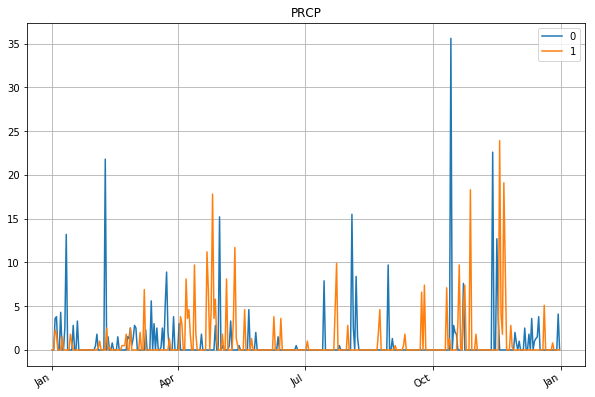

In [8]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');
#only plot two year of data

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [10]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

In [9]:
plot_pair(['TMIN','TMAX'],plot_valid)

NameError: name 'plot_pair' is not defined

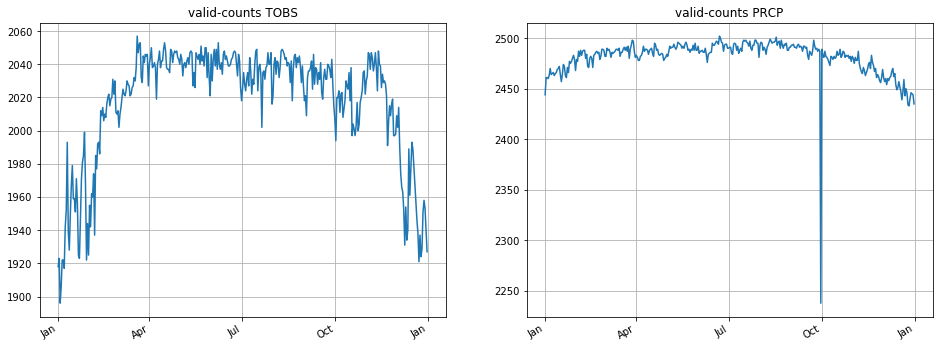

In [13]:
plot_pair(['TOBS','PRCP'],plot_valid)

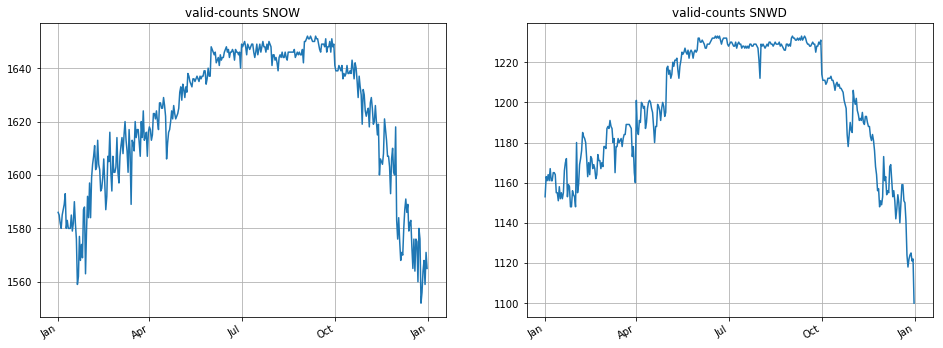

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [15]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']/10
    std=np.sqrt(STAT[m]['Var'])/10 #divide by ten to transfer to centigrade
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

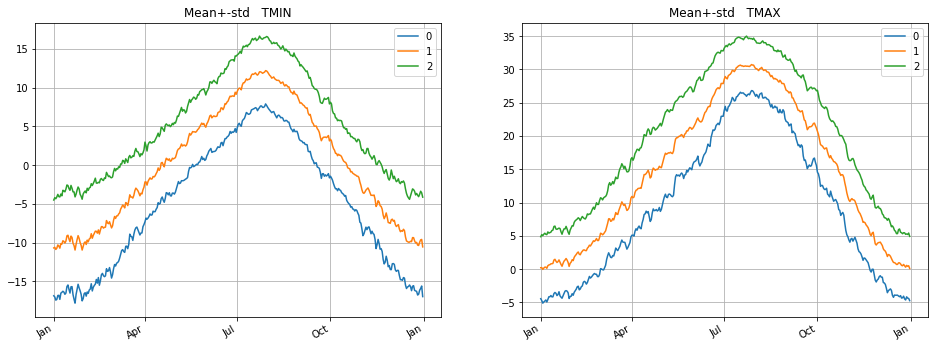

In [17]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

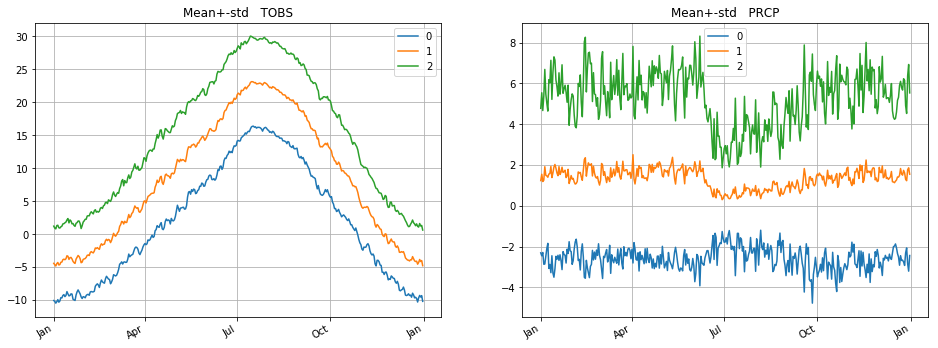

In [16]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

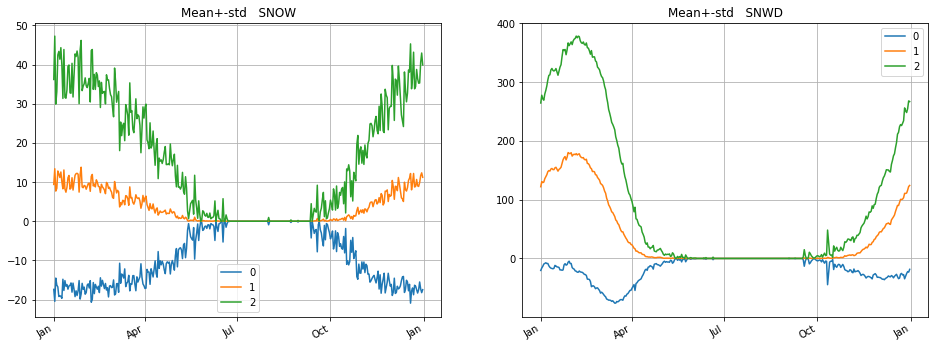

In [21]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [22]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

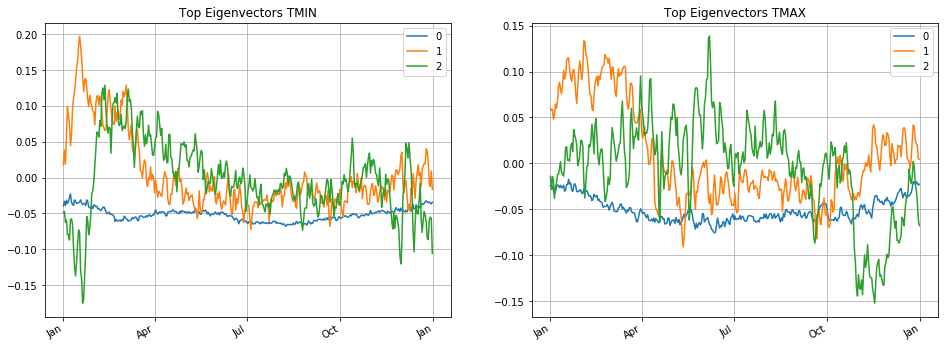

In [23]:
plot_pair(['TMIN','TMAX'],plot_eigen)

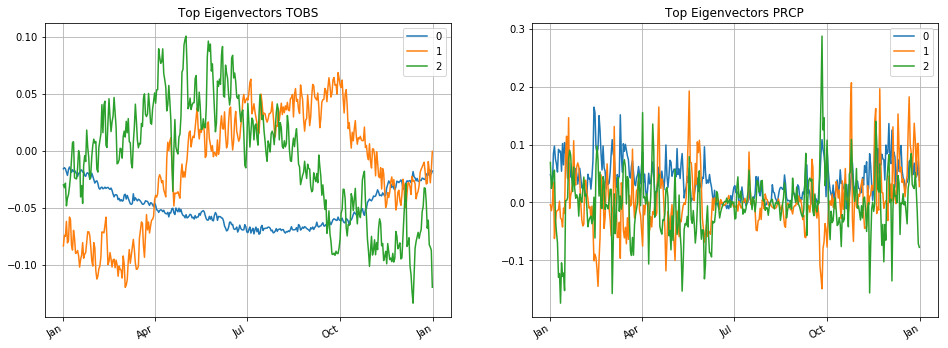

In [24]:
plot_pair(['TOBS','PRCP'],plot_eigen)

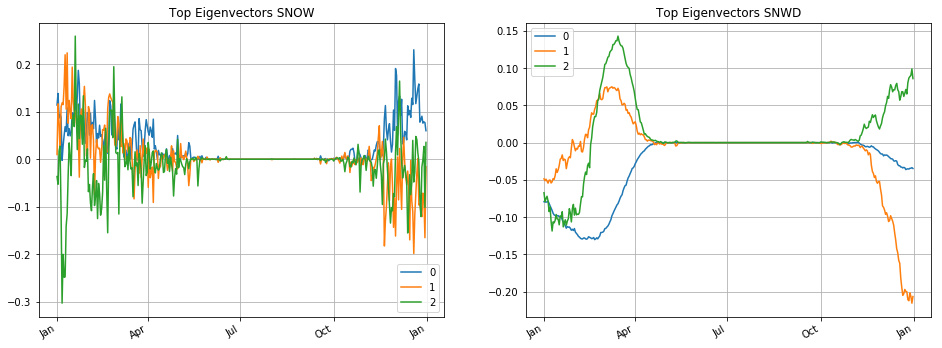

In [25]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [18]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

[ 270547.31484672  303597.91175058]


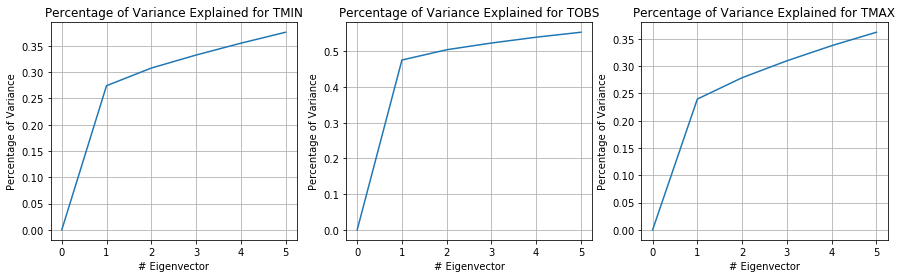

In [19]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
#shape(STAT['TMIN']['eigval'])
print cumsum(STAT['TMIN']['eigval'][:2])

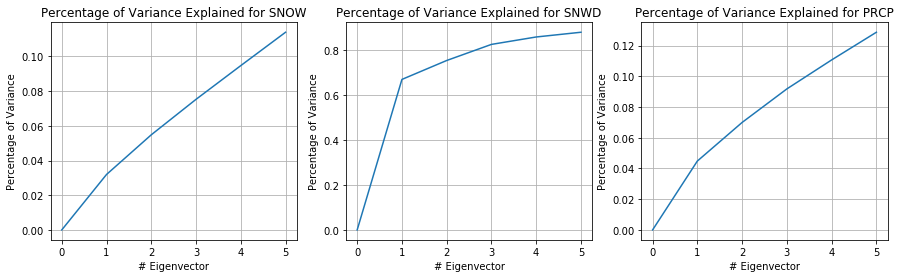

In [20]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [28]:
sc.stop()